In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from util import setup_environment

# Configuration flags
force_compute = True
is_debug = False

output_dir = setup_environment()

In [2]:
# Read the sequential test results from CSV files generated by 01_sequential.ipynb
seq_time_detail_path = os.path.join(output_dir, "sequential_output_time.csv")
seq_memory_path = os.path.join(output_dir, "sequential_output_memory.csv")

# Read the CSV files
if os.path.exists(seq_time_detail_path):
    df = pd.read_csv(seq_time_detail_path)
    df["Time_s"] = df["Time_s"].astype(float)
    df["Memory_GB"] = df["Memory_GB"].astype(float)
    
    # Prepare dataframes sorted by time and memory
    df_time = df.sort_values(by="Time_s", ascending=False)
    df_memory = df.sort_values(by="Memory_GB", ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)
    
    # Plot descending run time
    _ = axes[0].bar(df_time['Notebook'], df_time['Time_s'], color='skyblue', alpha=0.5)
    _ = axes[0].set_title("Test Time (s) Descending")
    _ = axes[0].set_xlabel("Notebook")
    _ = axes[0].set_ylabel("Test Time (s)")
    _ = axes[0].tick_params(axis='x', rotation=90)
    
    # Plot descending memory
    _ = axes[1].bar(df_memory['Notebook'], df_memory['Memory_GB'], color='salmon', alpha=0.5)
    _ = axes[1].set_title("Memory Used (GB) Descending")
    _ = axes[1].set_xlabel("Notebook")
    _ = axes[1].set_ylabel("Memory Used (GB)")
    _ = axes[1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show();
    
    # save png
    fig.savefig(os.path.join(output_dir, "sequential_output.png"))
    print(f"Generated sequential_output.png with {len(df)} test results")
else:
    print(f"Warning: {seq_time_detail_path} not found. Run 01_sequential.ipynb first.")

Compute speedup = (sequential no-Parsl time) / (parallel Parsl time)

   workers    time   speedup
0        2  322.83  1.451693
Saved plot to output/parallel_times_speedup.png


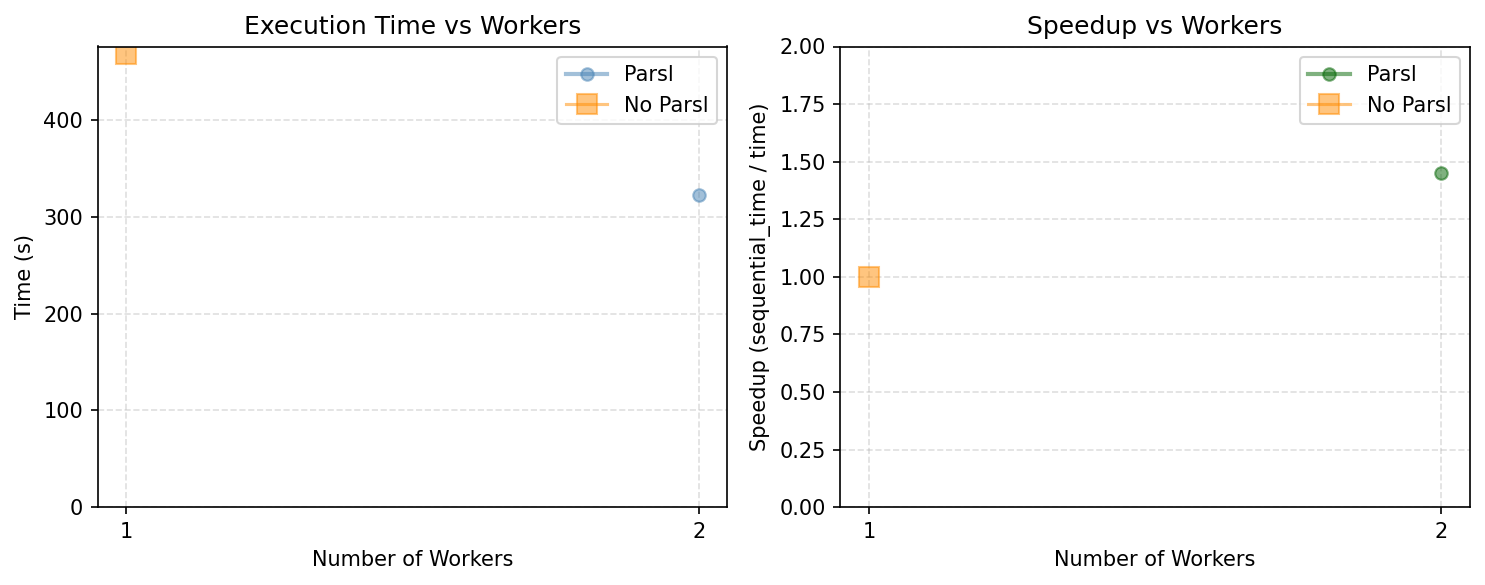

In [3]:
# Read sequential time from sequential_time.csv
seq_time_path = os.path.join(output_dir, "sequential_time.csv")
if os.path.exists(seq_time_path):
    with open(seq_time_path, "r") as f:
        sequential_time = float(f.read().strip())
else:
    # Fallback: try to extract from sequential_output.csv
    match = re.search(r"Ran \d+ tests? in ([\d\.]+)s", text)
    if match:
        sequential_time = float(match.group(1))
    else:
        sequential_time = 0.0

# Collect all dataframes first, then concatenate once
dfs = []
for worker in range(1, 17):
    fname  = f"parallel_times_{worker}.csv"
    if not os.path.exists(os.path.join(output_dir, fname)):
        continue

    # read CSV of parallel times if it exists
    df_tmp = pd.read_csv(output_dir+os.sep+fname)
    dfs.append(df_tmp)

# Concatenate all at once (avoids FutureWarning about empty DataFrame concat)
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    df["speedup"] = sequential_time / df["time"]      # Compute speedup
else:
    df = pd.DataFrame(columns=["workers", "time", "speedup"])
    
print(df)

# [1, sequential_time, 1.0] to df2 (sequential baseline)
df2 = pd.DataFrame({
    "workers": [1],
    "time": [sequential_time],
    "speedup": [1.0]
})

times = df["time"] if "time" in df.columns else pd.Series([])
workers = df["workers"] if "workers" in df.columns else pd.Series([])
speedup = df["speedup"] if "speedup" in df.columns else pd.Series([])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# Execution times
# Only plot if both workers and times arrays are non-empty and have the same length
if workers.size > 0 and times.size > 0 and workers.shape == times.shape:
    axes[0].plot(workers, times, marker="o", lw=2, color="steelblue", label="Parsl", alpha=0.5);
else:
    axes[0].text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
# Add No Parsl baseline point
axes[0].plot(df2["workers"], df2["time"], marker="s", markersize=10, color="darkorange", label="No Parsl", alpha=0.5);
axes[0].set_xlabel("Number of Workers")
axes[0].set_ylabel("Time (s)")
axes[0].set_title("Execution Time vs Workers")
axes[0].set_ylim(bottom=0)  # Start y-axis at 0
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.4)
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Speedup
# Only plot if both workers and speedup arrays are non-empty and have the same length
if workers.size > 0 and speedup.size > 0 and workers.shape == speedup.shape:
    axes[1].plot(workers, speedup, marker="o", lw=2, color="darkgreen", label="Parsl", alpha=0.5);
else:
    axes[1].text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
# Add No Parsl baseline point
axes[1].plot(df2["workers"], df2["speedup"], marker="s", markersize=10, color="darkorange", label="No Parsl", alpha=0.5);
axes[1].set_xlabel("Number of Workers")
axes[1].set_ylabel("Speedup (sequential_time / time)")
axes[1].set_title("Speedup vs Workers")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Set top of speedup y-axis to the maximum speedup rounded to integer (minimum 1)
import math
max_speed = 1.0
try:
    # consider both measured speedups and the sequential baseline
    measured_max = df["speedup"].max() if ("speedup" in df.columns and not df["speedup"].empty) else 0.0
    baseline = df2["speedup"].max() if not df2["speedup"].empty else 1.0
    max_speed = max(measured_max, baseline, 1.0)
except Exception:
    max_speed = 1.0

top = max(1, int(math.ceil(float(max_speed))))
axes[1].set_ylim(0, top)

plt.tight_layout()
outname = os.path.join(output_dir, "parallel_times_speedup.png")
plt.savefig(outname, dpi=300, bbox_inches="tight")
print(f"Saved plot to {outname}")
plt.show();

In [4]:
!ls -ltr output/
!date

total 328
-rw-r--r--@ 1 terrya  staff    6380 Dec  4 16:21 01_sequential_output.ipynb
-rw-r--r--@ 1 terrya  staff    4501 Dec  4 16:21 parallel_output_2.txt
-rw-r--r--@ 1 terrya  staff      22 Dec  4 16:21 parallel_times_2.csv
-rw-r--r--@ 1 terrya  staff    6267 Dec  4 16:21 sequential_output.csv
-rw-r--r--@ 1 terrya  staff       7 Dec  4 16:21 sequential_time.csv
-rw-r--r--@ 1 terrya  staff  122313 Dec  4 16:27 parallel_times_speedup.png
Thu Dec  4 16:27:14 CST 2025
Thu Dec  4 16:27:14 CST 2025
